## Model fit


The likelihood function (often simply called the likelihood) is the joint probability (or probability density) of observed data viewed as a function of the parameters of a statistical model. By combining the likelihood function to a code able to explore the parameter space of our model (or a sampler), we can determine the probability density of the model parameters given the data, or posteriors. The posteriors of our model effectively represents the final results of our analysis.



La Likelihood Function (Funzione di Verosimiglianza) è una funzione che descrive la probabilità di ottenere un insieme di dati osservati, dato un particolare modello e un insieme di parametri. In altre parole, quantifica quanto bene un modello teorico riproduce i dati osservati. Nell'analisi dei transiti planetari, nella fotometria differenziale o nella modellizzazione delle curve di luce, la funzione di verosimiglianza viene utilizzata per stimare i parametri ottimali del modello confrontandoli con i dati osservati.

## Likelihood function

We consider N observations of a variable $y = (y_i)_{i=1,...,N}$, taken at times $t = (t_i)$, with associated measurements uncertainties $\sigma = (\sigma_i)$. We wish to compare these model function $m (t_i, \theta)$ controlled by parameters $\theta = (\theta_j)_{j=1,...,M}$.

let us assume that the observations are given by: $y_i = m (t_i, \theta) + \epsilon_i$

where $\epsilon_i$ is the measurement error, or noise, of the $i^{th}$ observation.

let us assume that $\epsilon_i$ is drawn from a Gaussian distribution with mean 0 and variance $\sigma_i^2$:

$p(\epsilon_i) = N(0,\sigma_i^2) = \frac{1}{\sqrt{2\pi}\sigma_i}exp(-\frac{\epsilon_i^2}{2\sigma_i^2})$

Then the likelihood for the $i^{th}$ observation is simply:

$L_i(\theta) = p(y_i|\theta) = N(m_i,\sigma_i^2) = \frac{1}{\sqrt{2\pi}\sigma_i}exp(-\frac{(y_i - m_i)^2}{2\sigma_i^2})$

The natural logarithm of $L$ is equal to:

$ln L = -0.5N ln 2\pi - \sum_{i=1}^N(ln\sigma_i)  - 0.5\chi^2$

where $\chi^2$ is equal to the weighted sum of squared deviations:

$\chi^2 = \sum_{i=1}^n \frac{(y_i - m_i)^2}{2\sigma_i^2}$

The above equation can be rewritten as:
$ln L = -0.5(N ln2\pi + \chi^2 + \sum_{i=1}^N(ln\sigma_i^2))$

### Building the log_likelihood function

Let's load our data first. You have to load the photometry that you evaluated as the best one according to the analysis performed on the TESS flattened light curves.

In [21]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits 
import pickle
%matplotlib widget


taste_bjd_tdb = pickle.load(open('../Differential Photometry/taste_bjdtdb.p','rb'))
#differential_allref = pickle.load(open('../TASTE_analysis/differential_ap11_ref01.p', 'rb'))
differential_allref = pickle.load(open('../Differential Photometry/differential_ap06_allref.p','rb'))
differential_allref_error = pickle.load(open('../Differential Photometry/differential_ap06_allref_error.p','rb'))


tess_sector80_dict = pickle.load(open('flatten_sector80_dictionary.p','rb'))
tess_bjd_tdb = tess_sector80_dict['time']
tess_normalized_flux = tess_sector80_dict['selected_flux']
tess_normalized_ferr = tess_sector80_dict['selected_flux_error']

As we have seen in the previous lecture, our model encompassed the usual parameters, common to both TASTE and TESS datasets.

For TESS, we have to include additional parameters for the limb darkening coefficients and three parameters for the coefficient of the quadratic polynomial trend:

- TESS limb darkening coefficient u1
- TESS limb darkening coefficient u2
- zero-th order coefficient for the polynomial trend
- first order coefficient
- second order coefficient

Finally, we add two extra parameters, called jitter parameters, which are not used by the model but are instead added in quadrature to estimate our errors. These parameters will compensate for any source of errors that we have not included in our estimates until now:

- jitter parameter for TESS data
- jitter parameter for TASTE data

We have a total of 14 parameters.

In [22]:
theta = np.empty(14)

theta[0] = 2459768.65359   #time of inferior conjunction
theta[1] = 1.4013795         #orbital period
theta[2] = 0.14         #planet radius (in units of stellar radii)
theta[3] = 5.61          #semi-major axis (in units of stellar radii)
theta[4] = 82.0           #orbital inclination (in degrees)
theta[5] = 0.49           # TESS LD coeff u1
theta[6] = 0.11           # TESS LD coeff u2
theta[7] = 0.62           # TASTE LD coeff u1
theta[8] = 0.93           # TASTE LD coeff u2
theta[9] = 0.251           # zero-th order coefficient for the polynomial trend
theta[10] = 0.0           # first order coefficient for the polynomial trend
theta[11] = 0.0           # second order coefficient for the polynomial trend
theta[12] = 0.0           # jitter parameter for TESS data
theta[13] = 0.0           # jitter parameter for TASTE data

In [23]:
import batman

params = batman.TransitParams()
params.t0 =  theta[0]                
params.per = theta[1]                    
params.rp =  theta[2]                
params.a =   theta[3]                   
params.inc =  theta[4]    
params.ecc = 0.
params.w = 90. 
params.u = [theta[5] , theta[6]]
params.limb_dark = "quadratic"

m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv

params.u = [theta[7] , theta[8]]
median_bjd = np.median(taste_bjd_tdb)
polynomial_trend = theta[9] + theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params) * polynomial_trend

Note how we multiply the model by the polynomial trend, rather than divide the data by it. The idea behind this choice is to include all possible effects in the model rather than work on the data. This approach will also avoid the extra step of dividing the associated errors by the polynomial trend. LEt's compare the data with our model:

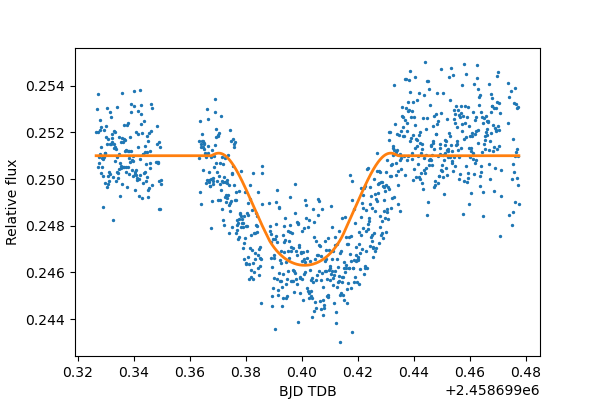

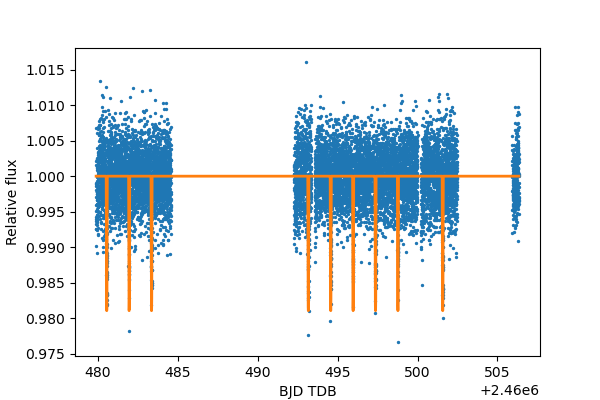

In [24]:
plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_allref, s=2)
plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

Let's compute the log-likelihood: 
$ln L = -0.5(N ln2\pi + \chi^2 + \sum_{i=1}^N(ln\sigma_i^2))$

If we have two dataset, for the properties of the sum the $\chi^2$ and the term $ln \sigma_i^2$ are equal to:

$\chi^2 = \chi_{TESS}^2 + \chi_{TASTE}^2$

$\sum_{i=1}^N (ln \sigma_i^2) = \sum_{i=1}^{N_{TESS}} (ln\sigma_i^2)+ \sum_{i=1}^{N_{TASTE}} (ln\sigma_i^2)$

with $N = N_{TESS} + N_{TASTE}$

The same considerations apply if you have several TESS sectors in addition to the TASTE observations, for example, data coming from TESS sectors 80, 79, 53:

$\chi^2 = \chi_{TESS-sector80}^2 + \chi_{TESS-sector79}^2 + \chi_{TESS-sector53}^2 + \chi_{TASTE}^2$

$\sum_{i=1}^N (ln \sigma_i^2) = \sum_{i=1}^{N_{TESS-sector80}} (ln\sigma_i^2) + \sum_{i=1}^{N_{TESS-sector79}} (ln\sigma_i^2) + \sum_{i=1}^{N_{TESS-sector53}} (ln\sigma_i^2) + \sum_{i=1}^{N_{TASTE}} (ln\sigma_i^2)$

with $N = N_{TESS-sector80} + N_{TESS-sector79} + N_{TESS-sector53} + N_{TASTE}$

We first start to add in quadrature the jitter to our estimated errors. We don't need to take the square root, as we are going to use the square of the result in the likelihood computation. We then proceed to build the rest of the code.

In [25]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
    tess_flux =m_tess.light_curve(params)          #calculates light curv

    params.u = [theta[7] , theta[8]]
    median_bjd = np.median(taste_bjd_tdb)
    polynomial_trend = theta[9]+theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

    m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    
    tess_errors_with_jitter = tess_normalized_ferr**2 + theta[12]**2
    
    taste_errors_with_jitter = differential_allref_error**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_tess = np.sum( (tess_normalized_flux-tess_flux)**2 / tess_errors_with_jitter)
    chi2_taste = np.sum( (differential_allref-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))
    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess + chi2_taste + sum_ln_sigma_tess + sum_ln_sigma_taste)
    return log_likelihood

print('log_likelihood', log_likelihood(theta))

log_likelihood -186965.26477770883


The number by itself is not very useful. What we need to do is to find the combination of parameters that maximise the log-likelihood (and, conversely, minimise the $\chi^2$). To do so, we need to build a function that takes in input the parameter vector $\theta$ and gives us the log-likelihood value in output. In practice, we just have to assemble the last cells' operations inside a function.

In [26]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
    tess_flux =m_tess.light_curve(params)          #calculates light curv

    params.u = [theta[7] , theta[8]]
    median_bjd = np.median(taste_bjd_tdb)
    polynomial_trend = theta[9]+theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

    m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    
    tess_errors_with_jitter = tess_normalized_ferr**2 + theta[12]**2
    
    taste_errors_with_jitter = differential_allref_error**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_tess = np.sum( (tess_normalized_flux-tess_flux)**2 / tess_errors_with_jitter)
    chi2_taste = np.sum( (differential_allref-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_tess = np.sum(np.log(tess_errors_with_jitter))
    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess + chi2_taste + sum_ln_sigma_tess + sum_ln_sigma_taste)
    return log_likelihood

print('log_likelihood', log_likelihood(theta))

log_likelihood -186965.26477770883


You don't need to introduce additional parameters in the model if you work with more than one TESS sector:
- you can use the same TESS limb darkening for all TESS sectors
- you can use the same jitter parameters for all TESS sectors

## Define the prior

Questa sezione discute la definizione delle distribuzioni a priori per i parametri del modello di transito. In un approccio bayesiano al fitting dei dati, i parametri del modello non sono trattati solo come valori sconosciuti da stimare, ma vengono assegnate distribuzioni a priori che riflettono la conoscenza preesistente sui parametri stessi. Questo aiuta a evitare valori non realistici e incorporare conoscenze precedenti.

Le prior possono essere di diversi tipi:
- Distribuzioni uniformi: Tutti i valori in un certo intervallo sono considerati equiprobabili.
- Distribuzioni gaussiane: Utilizzate quando si hanno misurazioni precedenti con incertezze note.
- Distribuzioni lognormali o Jeffreys: Utili per parametri come il periodo orbitale, che possono variare su più ordini di grandezza.

These are the limb darkening coefficients that I retrieved for my filters:
- Sloan r LD coefficients: $u1 = 0.6215 \pm 0.0342$ , $u2 = 0.0959 \pm 0.0818$
- TESS LD coefficients: $u1 = 0.49 \pm 0.02$ , $u2 = 0.11 \pm 0.06$

How do I incorporate this information in the computation of the posterior? The Bayes theorem says:

$P(x|D) = \frac{P(D|x)P(x)}{P(D)}$

Our sampler works by taking the natural logarithm of the likelihood, so priors can be included easily by adding the logarithm of the probability density function of the parameters over which we want to impose a prior.

Depending on how much you trust your prior, you can keep the error estimate as predicted from theory or inflate the error associated with the median value according to other considerations. 

The probability density function can be easily computed using scipy:

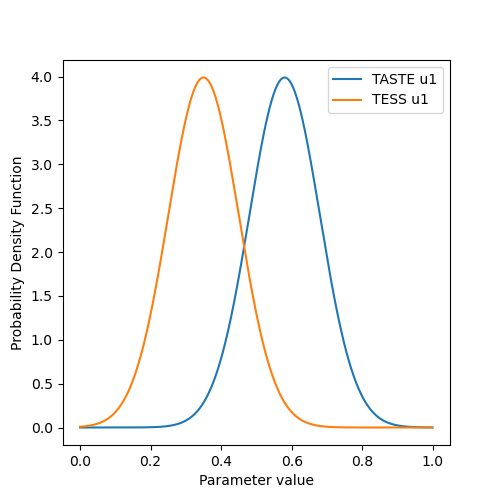

In [27]:
from scipy import stats

TASTE_u1 = 0.6215
TASTE_u2 = 0.0959
TESS_u1 = 0.49
TESS_u2 = 0.11

x_range=np.arange(0.00, 1.00, 0.001)
y1_plot = stats.norm.pdf(x_range, loc=0.58, scale=0.10)
y2_plot = stats.norm.pdf(x_range, loc=0.35, scale=0.10)
plt.figure(figsize=(5,5))
plt.plot(x_range, y1_plot, label='TASTE u1')
plt.plot(x_range, y2_plot, label='TESS u1')
plt.xlabel('Parameter value')
plt.ylabel('Probability Density Function')
plt.legend()
plt.show()

To correctly assign the prior, we need to keep track of the index associated with the parameters with explicit prior. Keep in mind that all parameters will have some kind of prior. If not explicitly stated, the prior is uniform, i.e., a constant value for the probability density distribution.

In [28]:
theta[5] = 0.49           # TESS LD coeff u1
theta[6] = 0.11           # TESS LD coeff u2
theta[7] = 0.6215           # TASTE LD coeff u1
theta[8] = 0.0959           # TASTE LD coeff u2

def log_prior(theta):
    prior = 0.00
    prior+= np.log(stats.norm.pdf(theta[5], loc=0.49, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[6], loc=0.11, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[7], loc=0.6215, scale=0.10))
    prior+= np.log(stats.norm.pdf(theta[8], loc=0.0959, scale=0.10))
    return prior

## Define the boundaries

Questa sezione stabilisce i limiti dei parametri del modello. A differenza delle prior, che assegnano probabilità ai valori dei parametri, i boundaries (limiti) impongono confini rigidi, oltre i quali i parametri non possono variare. Questo è essenziale per impedire soluzioni non fisiche e migliorare la convergenza dell'algoritmo di ottimizzazione.

Tipicamente, i limiti vengono fissati sulla base di aspetti fisici, dati osservativi e considerazioni numeriche

Defining the boundaries of our parameters is not explicitly required by the sampler we employ, but it may be compulsory for other samplers. In general, proving boundaries for the parameter spaces is always helpful as it will avoid exploring unphysical parameter combinations.

The boundary array is a two-dimensional array, with one dimension equal to the number of parameters of the model and the other dimension equal to two. Written in this way, it will be trivial to check if the $\theta$ array is within the boundaries.

In [29]:
theta[0] = 2459768.65359   #time of inferior conjunction
theta[1] = 1.4013795         #orbital period
theta[2] = 0.14         #planet radius (in units of stellar radii)
theta[3] = 5.61          #semi-major axis (in units of stellar radii)
theta[4] = 82.0           #orbital inclination (in degrees)
theta[5] = 0.49           # TESS LD coeff u1
theta[6] = 0.11           # TESS LD coeff u2
theta[7] = 0.62           # TASTE LD coeff u1
theta[8] = 0.93           # TASTE LD coeff u2
theta[9] = 0.251           # zero-th order coefficient for the polynomial trend
theta[10] = 0.010           # first order coefficient for the polynomial trend
theta[11] = 0.242           # second order coefficient for the polynomial trend
theta[12] = 0.0035           # jitter parameter for TESS data
theta[13] = 0.0012         # jitter parameter for TASTE data


boundaries = np.empty([2, len(theta)])

boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
boundaries[:,2] = [0.0, 0.5]
boundaries[:,3] = [0.0, 20.]
boundaries[:,4] = [0.00, 90.0]
boundaries[:,5] = [0.00, 1.0]
boundaries[:,6] = [0.00, 1.0]
boundaries[:,7] = [0.00, 1.0]
boundaries[:,8] = [0.00, 1.0]
boundaries[:,9] = [0.00, 1.0]
boundaries[:,10] = [-1.0, 1.0]
boundaries[:,11] = [-1.0, 1.0]
boundaries[:,12] = [0.0, 0.05]
boundaries[:,13] = [0.0, 0.05]

If $\theta$ is outside the range, the log_probability will be -np.inf, and the sampler will reject the step. Otherwise, the sum of log_likelihood and log_prior will be computed.

In [30]:
def log_probability(theta):
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_prob = log_prior(theta)

    log_prob += log_likelihood(theta)
    return log_prob

print('log_probability', log_probability(theta))


log_probability 49420.270588324034


## Running the MCMC sample

L'MCMC è una tecnica statistica usata per esplorare lo spazio dei parametri e trovare le migliori stime in base ai dati osservati. In questa sezione vengono trattati:

1. Setup del campionamento MCMC:

   - Viene usata la libreria emcee, una libreria Python che implementa un affine-invariant ensemble sampler.
   - Si definisce la likelihood (funzione di verosimiglianza) del modello rispetto ai dati osservativi.
   - Si inizializzano i walker, ovvero le catene MCMC, con distribuzioni iniziali coerenti con le prior.

2. Esecuzione del campionamento:

   - Si avvia l’MCMC facendo evolvere i walker nel tempo.
   - Vengono definiti il numero di step e il numero di walker (tipicamente 50-100 per parametro).
   - Il codice salva periodicamente i risultati per monitorare la convergenza.

3. Controllo della convergenza:

   - Si usano metriche come l’autocorrelazione per verificare che il campionamento abbia esplorato bene lo spazio dei parametri.
   - Se necessario, si estende la durata del campionamento per garantire una stima affidabile dei parametri.

3. Analisi dei risultati:

   - Si creano corner plot per visualizzare le distribuzioni a posteriori dei parametri.
   - Vengono estratti i valori medi e gli intervalli di confidenza per i parametri del modello di transito.


L'obiettivo di questa sezione è ottenere stime affidabili per parametri come tempo di congiunzione $t_0$, periodo orbitale, raggio del pianeta $R_p/R_s$ e coefficenti di limb darkening, basandosi sui dati osservativi e sulle prior definite in precedenza.

The number of walkers needs to be at least twice the number of parameters for the algorithm to work properly (this is a specific requirement of the affine invariant MCMC). The number of steps must be long enough for the chains to converge and mix. Note that:
- increasing the walker sill make each iteration slower
- increasing the steps will make the total time longer

In [31]:
import emcee

nwalkers = 28
nsteps = 50000
ndim = len(theta)

We also need to provide a starting point for the MCMC. We can safely use the theta that we have built earlier, with a caveat: the sampler requires each chain to be initialized at a slightly different position with respect to the other, so we are going to build an array with shape (nwalkers, ndim) by perturbing our starting point $\theta$ by a small value.

In [32]:
#We initialize the walkers in a tiny Gaussian ball around our approximate result
starting_point = theta + np.abs(1e-5 * np.random.randn(nwalkers, ndim))

print(np.shape(starting_point))

(28, 14)


It's quite slow, let's try a trick with multiprocessing:



In [33]:
#from multiprocessing import Pool

In [34]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(starting_point, nsteps, progress=True)

  6%|▌         | 3033/50000 [01:59<26:39, 29.36it/s]  Traceback (most recent call last):
  File "c:\Users\Lorenzo\anaconda3\Lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_13552\2797298044.py", line 9, in log_probability
    log_prob += log_likelihood(theta)
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_13552\189802736.py", line 18, in log_likelihood
    median_bjd = np.median(taste_bjd_tdb)
                 ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lorenzo\anaconda3\Lib\site-packages\numpy\lib\function_base.py", line 3927, in median
    return _ureduce(a, func=_median, keepdims=keepdims, axis=axis, out=out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lorenzo\anaconda3\Lib\site-packages\numpy\lib\function_base.py", line 3823, in _ure

emcee: Exception while calling your likelihood function:
  params: [2.45976865e+06 1.40137826e+00 1.01619987e-01 7.22837788e+00
 8.77535983e+01 5.53180382e-01 2.54541481e-01 9.59881156e-01
 3.16039337e-01 2.50434131e-01 1.00998935e-02 2.66030448e-01
 3.52327822e-03 1.27754499e-03]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
pickle.dump(sampler, open('emcee_sampler_first_run.p','wb'))

## Analysis of the results

We can visualize the chain to verify that the MCMC has reached convergence. We have to check all the parameters.

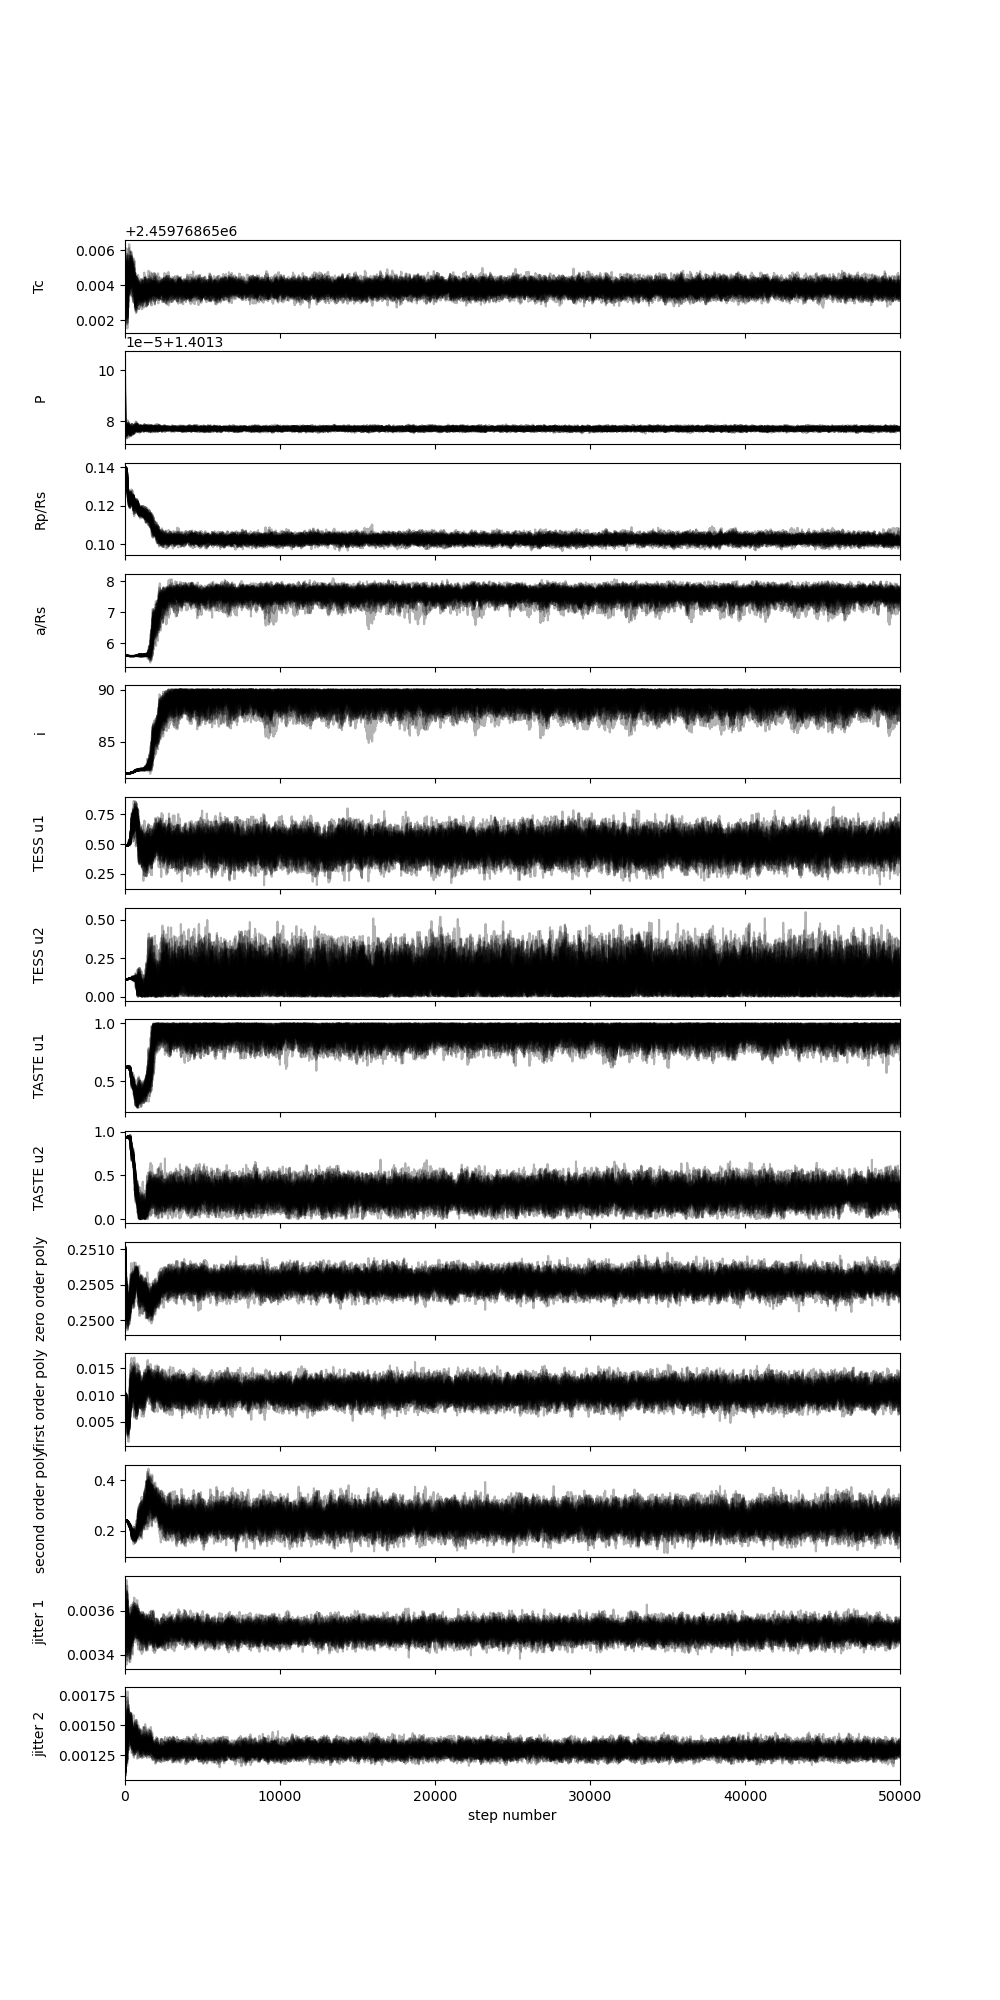

In [ ]:
sampler = pickle.load(open('emcee_sampler_first_run.p','rb'))

fig, axes = plt.subplots(14, figsize=(10, 20), sharex=True)
samples = sampler.get_chain()
labels = ["Tc", "P", "Rp/Rs", "a/Rs", "i", "TESS u1", "TESS u2", "TASTE u1", "TASTE u2", "zero order poly", "first order poly", "second order poly", "jitter 1", "jitter 2"]
for i in range(14):               # <-- INSERISCI NUMERO PARAMETRI                            
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Nel grafico che hai generato, ci sono due tipi di linee:
1. Le linee nere rappresentano le traiettorie dei walker nell’MCMC.
   - Ogni walker è una catena indipendente che esplora lo spazio dei parametri, quindi la densità di linee nere indica quanto bene i walker stanno campionando la distribuzione.
   - Dopo la fase iniziale ("burn-in"), i walker dovrebbero stabilizzarsi attorno a valori coerenti.
2. Le linee grigie indicano probabilmente i percorsi mediati o la varianza dei campioni.
   - Possono rappresentare la media mobile dei parametri lungo gli step, mostrando come si stanno stabilizzando nel tempo.
   - Se sono molto diverse dalle linee nere, significa che ci sono ancora grandi variazioni nei campioni.


### Valori per i parametri usando MCMC

In [ ]:
flat_samples = sampler.get_chain(discard=3000, thin=100, flat=True)
print(flat_samples.shape)

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))


#theta[0] = 2459768.65359   #time of inferior conjunction
#theta[1] = 1.4013795         #orbital period
#theta[2] = 0.14         #planet radius (in units of stellar radii)
#theta[3] = 5.61          #semi-major axis (in units of stellar radii)
#theta[4] = 82.0           #orbital inclination (in degrees)
#theta[5] = 0.49           # TESS LD coeff u1
#theta[6] = 0.11           # TESS LD coeff u2
#theta[7] = 0.62           # TASTE LD coeff u1
#theta[8] = 0.93           # TASTE LD coeff u2
#theta[9] = 0.251           # zero-th order coefficient for the polynomial trend
#theta[10] = 0.0           # first order coefficient for the polynomial trend
#theta[11] = 0.0           # second order coefficient for the polynomial trend
#theta[12] = 0.0           # jitter parameter for TESS data
#theta[13] = 0.0           # jitter parameter for TASTE data


(13160, 14)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Finally, we can plot the corner plot, highlighting possible correlations between parameters and non-Gaussian posterior distributions.

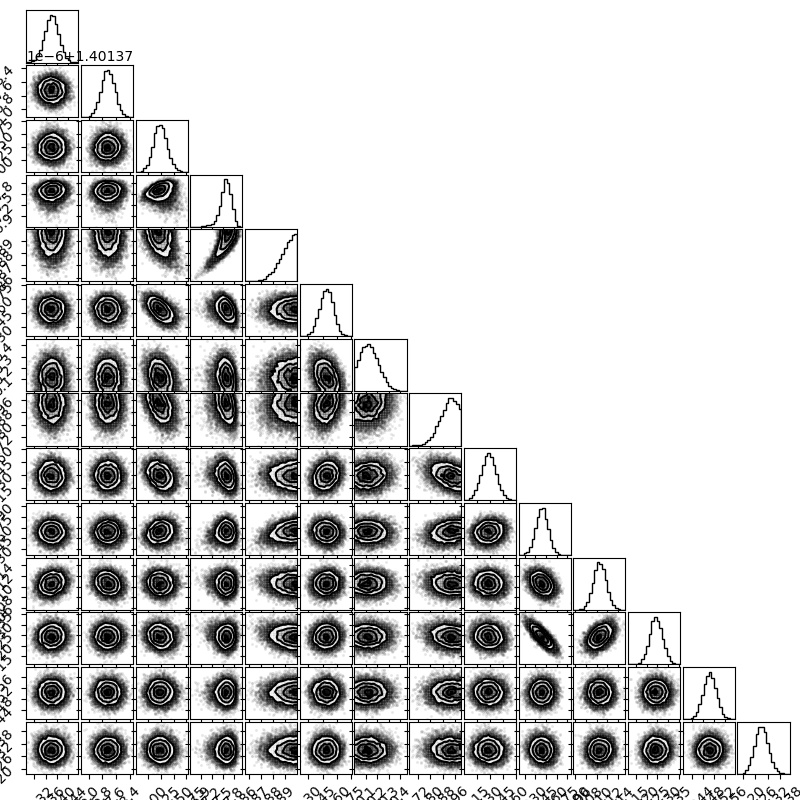

In [ ]:
### Job for you: make the labels

import corner

fig = plt.figure(figsize=(8,8))
corner.corner(flat_samples, fig=fig)

plt.show() 

Finally, you can overplot the model over your data by using the median values of the parameters' posteriors.

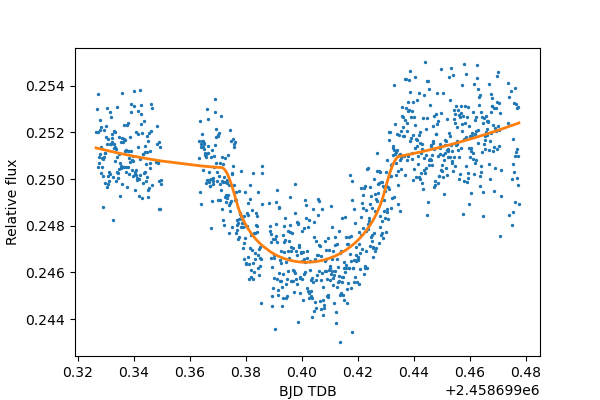

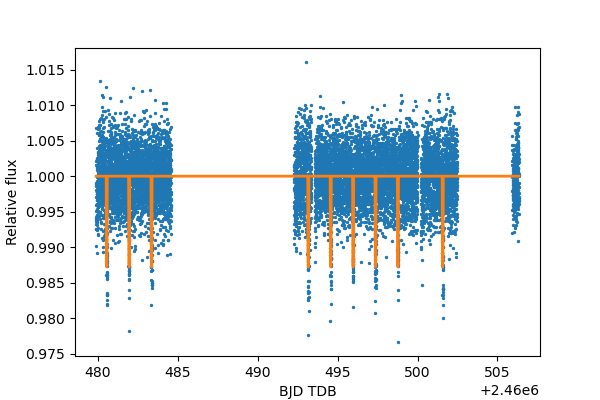

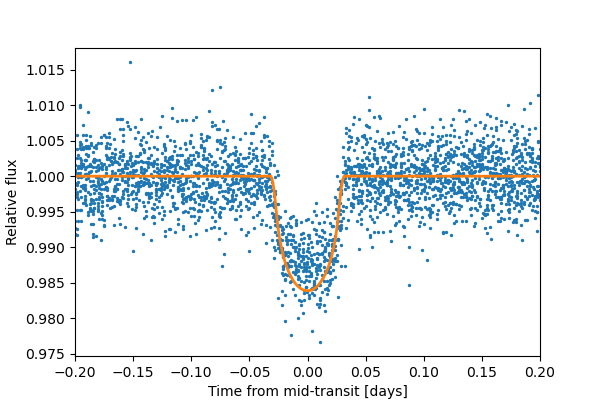

In [ ]:
theta = np.median(flat_samples, axis=0)

params = batman.TransitParams()
params.t0 =  theta[0]                
params.per = theta[1]                    
params.rp =  theta[2]                 
params.a =   theta[3]                   
params.inc =  theta[4]    
params.ecc = 0.
params.w = 90. 
params.u = [theta[5] , theta[6]]
params.limb_dark = "quadratic"

m_tess = batman.TransitModel(params, tess_bjd_tdb)    #initializes model
tess_flux =m_tess.light_curve(params)          #calculates light curv

params.u = [theta[7] , theta[8]]
median_bjd = np.median(taste_bjd_tdb)
polynomial_trend = theta[9] + theta[10]*(taste_bjd_tdb-median_bjd) + theta[11]*(taste_bjd_tdb-median_bjd)**2

m_taste = batman.TransitModel(params, taste_bjd_tdb)    #initializes model
taste_flux = m_taste.light_curve(params) * polynomial_trend

plt.figure(figsize=(6,4))
plt.scatter(taste_bjd_tdb, differential_allref, s=2)
plt.plot(taste_bjd_tdb, taste_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(tess_bjd_tdb, tess_normalized_flux, s=2)
plt.plot(tess_bjd_tdb, tess_flux, lw=2, c='C1')
plt.xlabel("BJD TDB")
plt.ylabel("Relative flux")
plt.show()


folded_tess_time = (tess_bjd_tdb - params.t0 - params.per/2. ) % params.per - params.per/2. 
folded_range = np.arange(- params.per/2.,  params.per/2., 0.001)

params.t0 = 0.                     #time of inferior conjunction
m_folded_tess = batman.TransitModel(params, folded_range)    #initializes model
tess_folded_flux =m_folded_tess.light_curve(params)          #calculates light curv
plt.figure(figsize=(6,4))
plt.scatter(folded_tess_time, tess_normalized_flux, s=2)
plt.plot(folded_range, tess_folded_flux, lw=2, c='C1')
plt.xlim(-0.2, 0.2)
plt.xlabel("Time from mid-transit [days]")
plt.ylabel("Relative flux")
plt.show()